# 24S2 SC3000/CZ3005 Assignment 1: Balancing a Pole on a Cart

This project implements a Q-learning algorithm to solve the classic CartPole-v1 environment from OpenAI Gym. The goal is to train an agent to balance a pole on a cart using reinforcement learning.

## Importing dependencies

In [78]:
# Import all the necessary libraries
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML, display
from IPython import display as ipythondisplay
from collections import defaultdict
import os

## Tutorial: Loading CartPole environment

Create the CartPole-v1 environment using OpenAI Gym. This environment simulates a cart balancing a pole and the goal is to keep the pole upright by applying forces to the cart.

In [79]:
# Create the CartPole-v1 environment
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

- 0 → left
- 1 → right

In [80]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to the following:
- Cart Position
- Cart Velocity
- Pole Angle
- Pole Angular Velocity

In [81]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [82]:
state, _ = env.reset()
print("Initial observations:", state)

Initial observations: [ 0.04503492 -0.0494108  -0.03658192 -0.04284194]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [83]:
state, reward, terminated, truncated, info = env.step(0)
done = terminated or truncated  # Combine both termination conditions

print("New observations after choosing action 0:", state)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.04404671 -0.2439896  -0.03743876  0.23807831]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [84]:
state, _ = env.reset()
cumulative_reward = 0
done = False
while not done:
    state, reward, terminated, truncated, info = env.step(0)
    done = terminated or truncated
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [85]:
def rand_policy_agent(state):
    return random.randint(0, 1)

For Task 1, we can show the observation and chosen action below:

In [86]:
state, _ = env.reset()
action = rand_policy_agent(state)
print("Observation:", state)
print("Chosen action:", action)

Observation: [ 0.03442585  0.04610343 -0.0232206   0.04080868]
Chosen action: 0


In this project, our agent uses the Q-learning algorithm to learn an optimal policy by updating a Q-table based on the Bellman equation. It balances exploration and exploitation using an epsilon-greedy strategy, and gradually shifts towards a greedy policy by decaying epsilon over time. The agent updates Q-values after every action and eventually exploits the best-known actions to maximize long-term rewards.

### Q-Learning ALgorithm

Q-learning is a value-based off-policy reinforcement learning algorithm that learns the optimal action-value function using the Bellman equation. The Q-value is updated using the **Bellman equation**:

$$
Q(s, a) = Q(s, a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right)
$$

where:  
- $ s $ = current state  
- $ a $ = action taken  
- $ r $ = reward received  
- $ s' $ = next state  
- $ a' $ = next possible action  
- $ \alpha $ = learning rate  
- $ \gamma $ = discount factor  

### Q-learning Parameters

- **Learning Rate**, $ \alpha = 0.1 $  
- **Discount Factor**, $ \gamma = 0.99 $  
- **Exploration Rate**, $ \epsilon = 1.0 $  
- **Epsilon Decay Rate**, $ \epsilon_{\text{decay}} = 0.9999 $  
- **Minimum Exploration Rate**, $ \epsilon_{\text{min}} = 0.05 $  

### Epsilon-Greedy Policy

To balance exploration and exploitation, the agent uses an epsilon-greedy policy:
- With probability $ \epsilon $, choose a **random action** (explore).  
- With probability $ 1 - \epsilon $, choose **best known action** (exploit).  
- Epsilon decays over time using:

$ \epsilon = \max(\epsilon \times \epsilon_{\text{decay}}, \epsilon_{\text{min}}) $

### State Space Discretization Bins

Since CartPole's state space is continuous, it is discretized into bins to make tabular Q-learning feasible. Each component of the state vector is mapped to a discrete bin:

| **State Variable**        | **Range**         | **Bins** |
|--------------------------|-------------------|----------|
| Cart Position            | [-4.8, 4.8]       | 30       |
| Cart Velocity            | [-4.0, 4.0]       | 30       |
| Pole Angle               | [-0.418, 0.418]   | 30       |
| Pole Angular Velocity    | [-4.0, 4.0]       | 30       |

These bins are used to convert the continuous environment states into discrete indices for Q-table lookup.

Training stopped early at episode 15185. Mean reward: 303.22


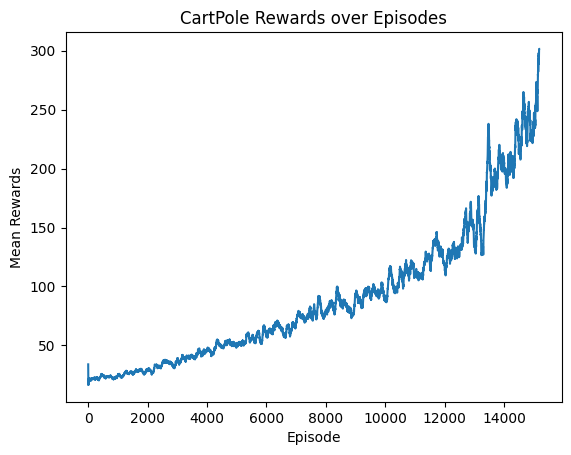

In [ ]:
# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_decay = 0.9999  # Slower decay rate for better exploration
epsilon_min = 0.05  # Minimum value of epsilon

rewards_per_episode = []  # List of rewards per episode
episode_count = 0  # Counter for episodes

# Discretization of state space
def discretize_state(state, bins):
    cart_pos, cart_vel, pole_angle, pole_ang_vel = state
    cart_pos_bin = np.digitize(cart_pos, bins[0])
    cart_vel_bin = np.digitize(cart_vel, bins[1])
    pole_angle_bin = np.digitize(pole_angle, bins[2])
    pole_ang_vel_bin = np.digitize(pole_ang_vel, bins[3])
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_ang_vel_bin)

# Create finer bins for discretization
bins = [
    np.linspace(-4.8, 4.8, 30),  # Cart Position
    np.linspace(-4.0, 4.0, 30),  # Cart Velocity
    np.linspace(-0.418, 0.418, 30),  # Pole Angle
    np.linspace(-4.0, 4.0, 30)  # Pole Angular Velocity
]

# Initialize Q-table
q_table = defaultdict(lambda: np.zeros(env.action_space.n))

# Q-learning training loop
while(True):
    state, _ = env.reset()
    state = discretize_state(state, bins)
    done = False
    total_reward = 0

    
    while not done:
        # Choose action using epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit best known action
        
        # Take action and observe new state and reward
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_state(next_state, bins)
        done = terminated or truncated
        total_reward += reward
        
        # Update Q-value using Bellman equation
        q_table[state][action] = (q_table[state][action] + alpha * 
                                  (reward + gamma * np.max(q_table[next_state]) - q_table[state][action]))
        
        state = next_state  # Move to next state
    
    episode_count += 1  # Increment episode count

    # Decay epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    
    # Append total reward for this episode
    rewards_per_episode.append(total_reward)

    # Check early stopping condition
    if len(rewards_per_episode) >= 100:
        mean_reward = np.mean(rewards_per_episode[-100:])  # Mean of last 100 episodes
        # Stop training if mean reward over the last 100 episodes is greater than 300
        if mean_reward > 300:
            print(f"Training stopped early at episode {episode_count}. Mean reward: {mean_reward}")
            break

env.close()

# Calculate the moving average of rewards over the last 100 episodes to smooth out the learning curve
mean_rewards = [np.mean(rewards_per_episode[max(0, t - 100):(t + 1)]) for t in range(len(rewards_per_episode))]

# Plot mean rewards over episodes
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean Rewards")
plt.title("CartPole Rewards over Episodes")
plt.savefig('cartpole_rewards.png')
plt.show()

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, we use the agent developed in Task 1 to play the game for 100 episodes, record the cumulative reward for each round, and plot the reward for each round. 

### Evaluation Criteria

- The agent is evaluated over 100 episodes using a greedy policy (always selecting the best-known action).

- For each episode, the cumulative reward is recorded — this is the total number of time steps the agent kept the pole balanced.

- The performance is considered "solved" if the average cumulative reward over 100 evaluation episodes exceeds 195.

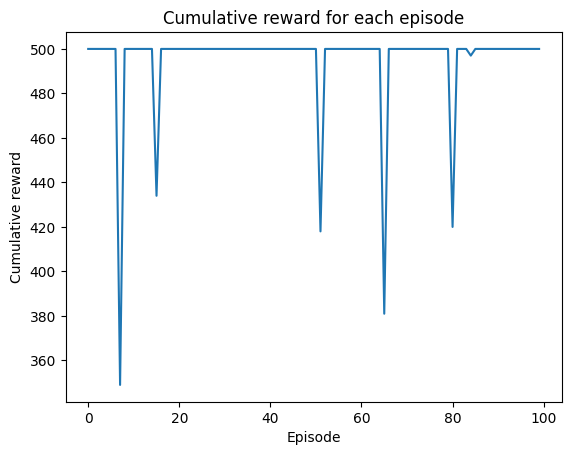

In [88]:
# Evaluate agent's performance
num_eval_episodes = 100
episode_results = []
for episode in range(num_eval_episodes):
    state, _ = env.reset()  # Reset environment at start of episode
    state = discretize_state(state, bins)  # Convert continuous state to discrete bins
    done = False
    cumulative_reward = 0
    
    while not done:
        action = np.argmax(q_table[state])  # Always exploit the best known action
        state, reward, terminated, truncated, _ = env.step(action)
        state = discretize_state(state, bins)  # Discretize next state
        done = terminated or truncated
        cumulative_reward += reward  # Accumulate reward for the episode
    
    episode_results.append(cumulative_reward)  # Store total reward for this episode

# Plot results
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

Print the average reward over the 100 episodes.

In [89]:
print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

Average cumulative reward: 494.99
Is my agent good enough? True


## Task 3: Render one episode played by the agent

After training is complete, we render a single episode using the learned Q-table to observe the agent's performance.
The episode is recorded and saved as a video file using the `RecordVideo` wrapper from Gym.

The function below (`show_video`) locates the latest recorded video from the `./video/` directory, encodes it in base64, and embeds it directly into the notebook for playback.

This allows us to visually inspect how well the agent performs using a fully greedy policy (always choosing the best action based on the trained Q-values).

In [95]:
# Function to display recorded video
def show_video():
    mp4list = glob.glob('./video/*.mp4')
    if len(mp4list) > 0:
        mp4 = max(mp4list, key=os.path.getctime)  # Show latest video
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data=f'''
            <video width="640" height="480" controls autoplay loop>
                <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4">
            </video>'''))
    else:
        print("Could not find video")

The `videoEpisode()` function runs one episode using the trained Q-table with a greedy policy and records it using Gym’s `RecordVideo`. The video is then displayed with `show_video()` to visually verify the agent's performance.

In [ ]:
# Function to run and record one episode
def videoEpisode():
    env = gym.make("CartPole-v1")  # Create environment
    env = RecordVideo(env, "./video")  # Record video of the episode

    state, _ = env.reset()
    state = discretize_state(state, bins)  # Convert continuous state to discrete bins
    done = False

    while not done:
        action = np.argmax(q_table[state])  # Use trained policy
        state, reward, terminated, truncated, _ = env.step(action)
        state = discretize_state(state, bins)  # Discretize next state
        done = terminated or truncated
        if done:
            break

    env.close()
    show_video()

# Run the video episode and display the recorded video
videoEpisode()

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
